# Chapter 11 - I2VIS

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

In [18]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

compute_timestep (generic function with 1 method)

In [90]:
# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation_center(grid::CartesianGrid,rho,Cp,kThermal,H,Tlast,dt)
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,0.0,0.0] # left,right,top,bottom
    
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    #        j-1   j     j   j+1   j+1
    #   i-1   |----kC----|----vy----|
    #         |          |          |
    #   i     kA    T   kB    T     |
    #         |          |          |
    #   i     |----kD--(i,j)--vy----|
    #         |          |          |
    #   i+1   vx    c    vx   c     vx
    #         |          |          |
    #   i+1   |----vy----|----vy----|
    
    for j in 1:grid.nx
        dxc = j>1 ? grid.x[j] - grid.x[j-1] : grid.x[j+1] - grid.x[j]
        dxp = grid.xc[j+1] - grid.xc[j]
        dxm = j>1 ? grid.xc[j]-grid.xc[j-1] : grid.xc[j+1] - grid.xc[j]
        for i in 1:grid.ny
            dyc = i>1 ? grid.y[i] - grid.y[i-1] : grid.y[i+1] - grid.y[i]
            dyp = grid.yc[i+1] - grid.yc[i]
            dym = i>1 ? grid.yc[i]-grid.yc[i-1] : grid.yc[i+1] - grid.yc[i]
            
            this_row = node_index(i,j,grid.ny);
            if i==1 # ghost nodes along top.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i+1,j,grid.ny)
                val[k] = bctop/2.0
                k+=1
                
                R[this_row] = bcval[3]
            elseif j==1 # ghost nodes along left side.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i,j+1,grid.ny)
                val[k] = bcleft/2.0
                k+=1
                
                R[this_row] = bcval[1]
            else            
                # kA, kB, kC, kD
                kA = 0.5*(kThermal[i-1,j-1] + kThermal[i,j-1])
                kB = 0.5*(kThermal[i,j]+kThermal[i-1,j])
                kC = 0.5*(kThermal[i-1,j-1] + kThermal[i-1,j])
                kD = 0.5*(kThermal[i,j-1] + kThermal[i,j])
                rho_c = 0.25*(rho[i-1,j-1] + rho[i,j-1] + rho[i-1,j] + rho[i,j])
                Cp_c = 0.25*(Cp[i-1,j-1] + Cp[i,j-1] + Cp[i-1,j] + Cp[i,j])

                # diagonal entry
                row[k] = this_row;
                col[k] = this_row;
                val[k] = (rho_c*Cp_c)/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
                k+=1
                # right
                row[k] = this_row;
                #col[k] = j==grid.nx ? node_index(i,2,grid.ny) : node_index(i,j+1,grid.ny);
                col[k] = j==grid.nx ? node_index(i,j,grid.ny) : node_index(i,j+1,grid.ny);
                val[k] = j==grid.nx ? bcright*kB/dxp/dxc : -kB/dxp/dxc;
                k+=1
                # left
                row[k] = this_row;
                col[k] = node_index(i,j-1,grid.ny);
                val[k] = -kA/dxm/dxc;
                k+=1
                # down (+y)
                row[k] = this_row;
                col[k] = i==grid.ny ? node_index(i,j,grid.ny) : node_index(i+1,j,grid.ny);
                val[k] = i==grid.ny ? bcbottom*kD/dyp/dyc : -kD/dyp/dyc;
                k+=1
                # up (-y)
                row[k] = this_row;
                col[k] = node_index(i-1,j,grid.ny);
                val[k] = -kC/dyp/dyc;
                k+=1
                R[this_row] = Tlast[i,j]*rho_c*Cp_c/dt;
                if j==grid.nx
                    R[this_row] += -2*bcval[2]*bcright*kB/dxp/dxc
                end
                if i==grid.ny
                    R[this_row] += -2*bcval[4]*bcbottom*kD/dyp/dyc
                end
            end
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 0.000
    end
end

initial_conditions! (generic function with 1 method)

In [91]:
nx = 51
ny = 71
W = 5e5
H = 5e5

vx = 1e-9
vy = 1e-9

# plot_interval = W/vx/20.

markx = 5
marky = 5
seconds_in_year = 3.15e7
plot_interval = 1e5*seconds_in_year # plot interval in seconds
end_time = W/vx # end time in seconds
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
@time initial_conditions!(markers)

# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
rho = zeros(grid.ny,grid.nx);
kThermal = zeros(grid.ny,grid.nx);
Cp = zeros(grid.ny,grid.nx);
H = zeros(grid.ny,grid.nx);
fill!(rho,3200.);
fill!(kThermal,3.0);
fill!(Cp,1000.);

dt = 1e9*seconds_in_year

tmp = marker_to_cell_center(markers,grid,["T",])
Tlast = tmp[1,:,:]

L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt)
Tnew = L\R
Tnew = reshape(Tnew,grid.ny,grid.nx)


Creating Markers...
  0.001830 seconds (21 allocations: 5.009 MiB)
Initial condition...
  0.002533 seconds


71×51 Matrix{Float64}:
 -1.66846  -1.66846  -1.67678  -1.69336  …  -1.69336  -1.67678  -1.66846
  1.66846   1.66846   1.67678   1.69336      1.69336   1.67678   1.66846
  5.00401   5.00401   5.02901   5.07884      5.07884   5.02901   5.00401
  8.33546   8.33546   8.37727   8.46061      8.46061   8.37727   8.33546
 11.66     11.66     11.7188   11.8361      11.8361   11.7188   11.66
 14.9746   14.9746   15.0508   15.2026   …  15.2026   15.0508   14.9746
 18.2763   18.2763   18.3701   18.5573      18.5573   18.3701   18.2763
 21.5616   21.5616   21.6736   21.897       21.897    21.6736   21.5616
 24.827    24.827    24.9577   25.2185      25.2185   24.9577   24.827
 28.0686   28.0686   28.2186   28.5178      28.5178   28.2186   28.0686
 31.2822   31.2822   31.4521   31.7911   …  31.7911   31.4521   31.2822
 34.4632   34.4632   34.6537   35.0339      35.0339   34.6537   34.4632
 37.6065   37.6065   37.8183   38.2411      38.2411   37.8183   37.6065
  ⋮                                     

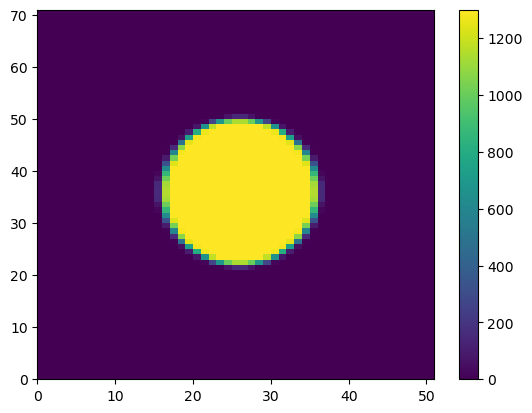

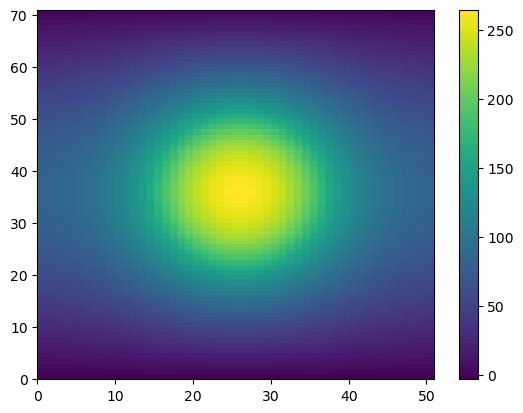

In [92]:
using PyPlot
figure()
pcolormesh(Tlast)
colorbar()
show()


figure()
pcolormesh(Tnew)
colorbar()
show()

In [89]:
Tnew[2,:] - Tnew[end,:]

51-element Vector{Float64}:
  1.2434497875801753e-14
  1.2434497875801753e-14
  1.2434497875801753e-14
  1.2878587085651816e-14
  1.354472090042691e-14
  1.3322676295501878e-14
  1.3988810110276972e-14
  1.4210854715202004e-14
  1.4432899320127035e-14
  1.509903313490213e-14
  1.509903313490213e-14
  1.4654943925052066e-14
  1.4654943925052066e-14
  ⋮
 -8.881784197001252e-16
 -6.661338147750939e-16
 -1.1102230246251565e-15
 -1.3322676295501878e-15
 -7.771561172376096e-16
 -6.661338147750939e-16
 -3.3306690738754696e-16
 -1.1102230246251565e-16
 -1.1102230246251565e-16
  5.551115123125783e-17
  5.551115123125783e-17
  2.7755575615628914e-17